In [115]:
import numpy as np
import theano, theano.tensor as T
import theano_ext as TX
import matplotlib.pyplot as plt
import scipy
import bayesian_pdes as bpdes
import gpanim
import bayesian_design as bd
%matplotlib inline

In [2]:
import sympy as sp
sp.init_printing()

In [3]:
def diagnose_function_2d(fun, fun_quad):
    fun, fun_quad = np.vectorize(fun), np.vectorize(fun_quad)
    x, y = np.mgrid[0:1:10j,0:1:10j]
    res = fun(x, y)
    res_quad = fun_quad(x, y)
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.title('Analytical')
    plt.colorbar(plt.contourf(x, y, res))
    plt.subplot(132)
    plt.title('Quadrature')
    plt.colorbar(plt.contourf(x, y, res_quad))
    plt.subplot(133)
    plt.title('Analytical - Quadrature')
    plt.colorbar(plt.contourf(x, y, res - res_quad))

# First calculate the integrals $\int\mathcal{A}k$, $\int\bar{\mathcal{A}}k$
Note that $\mathcal{A}k(x, x^\prime) = \bar{\mathcal{A}}k(x^\prime, x)$, so we only have to calculate the former.

In [4]:
x_1, x_2, z_1, z_2 = sp.symbols('x_1 x_2 z_1 z_2')

In [5]:
def Ak_quad(x_1, x_2):
    def __integrand(z_2):
        G = (x_2 > z_2) * (x_2 - z_2) + (z_2 - 1) * x_2
        Lambda = (1 - abs(x_1 - z_2))**3 *( 3 * abs(x_1 - z_2) + 1)
        return G * Lambda
    return scipy.integrate.quad(__integrand, 0, 1)[0]
def Abark_quad(x_1, x_2):
    def __integrand(z_1):
        G = (x_1 > z_1) * (x_1 - z_1) + (z_1 - 1) * x_1
        Lambda = (1 - abs(z_1 - x_2))**3 *( 3 * abs(z_1 - x_2) + 1)
        return G * Lambda
    return scipy.integrate.quad(__integrand, 0, 1)[0]
Ak_quad = np.vectorize(Ak_quad)
Abark_quad = np.vectorize(Abark_quad)

In [6]:
int_1 = (x_2 - z_2)*(1 - (x_1-z_2))**3 * (3*(x_1-z_2) + 1)
int_2 = (x_2 - z_2)*(1 - (z_2-x_1))**3 * (3*(z_2-x_1) + 1)
int_3 = (x_2)*(z_2 - 1)*(1 - (x_1-z_2))**3 * (3*(x_1-z_2) + 1)
int_4 = (x_2)*(z_2 - 1)*(1 - (z_2-x_1))**3 * (3*(z_2-x_1) + 1)

In [7]:
integrated_3_4 = sp.integrate(int_3, (z_2, 0, x_1)) + sp.integrate(int_4, (z_2, x_1, 1))
region_x_gt_xprime = sp.integrate(int_1, (z_2, 0, x_2)) + integrated_3_4
region_x_lt_xprime = sp.integrate(int_1, (z_2, 0, x_1)) + sp.integrate(int_2, (z_2, x_1, x_2)) + integrated_3_4

lambda_x_gt_xprime = sp.lambdify((x_1, x_2), region_x_gt_xprime)
lambda_x_lt_xprime = sp.lambdify((x_1, x_2), region_x_lt_xprime)
Ak = lambda x_1, x_2: lambda_x_gt_xprime(x_1, x_2) if x_1 > x_2 else lambda_x_lt_xprime(x_1, x_2)
Abark = lambda x_1, x_2: Ak(x_2, x_1)
Lambda = lambda x_1, x_2: (1 - abs(x_1 - x_2))**3*(3*abs(x_1-x_2) + 1)

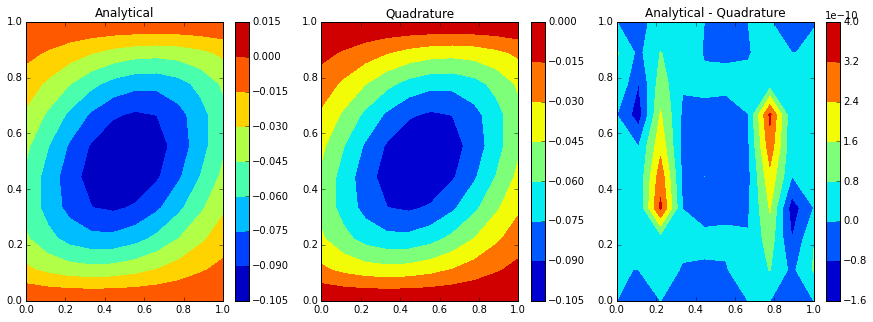

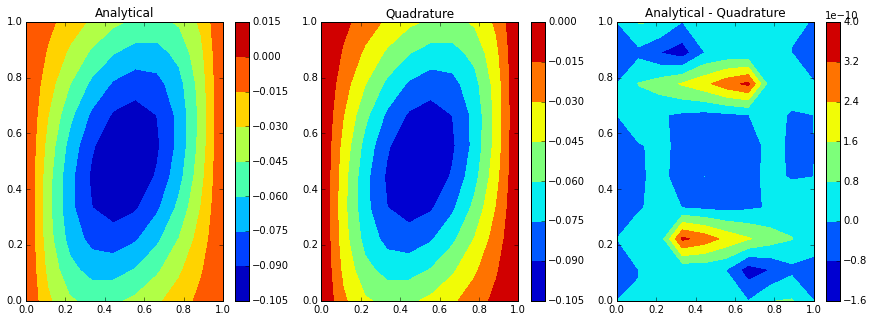

In [8]:
diagnose_function_2d(Ak, Ak_quad)
diagnose_function_2d(Abark, Abark_quad)

# Next calculate $k$ itself
This is even more verbose......!

In [9]:
Lambda_L = lambda x_1, x_2: (1 - (x_1 - x_2))**3*(3*(x_1-x_2) + 1)
Lambda_R = lambda x_1, x_2: Lambda_L(x_2, x_1)

In [10]:
# Assume x_1 < x_2 WLOG since A(x_1, x_2) = A(x_2, x_1)
integrand_A1 = (x_1-z_1)*(x_2-z_2)*Lambda_L(z_1, z_2)
integrand_A2 = (x_1-z_1)*(x_2-z_2)*Lambda_R(z_1, z_2)
int_A = sp.integrate(integrand_A1, (z_2, 0, z_1), (z_1, 0, x_1)) \
        + sp.integrate(integrand_A2, (z_2, z_1, x_2), (z_1, 0, x_1))
int_A = sp.lambdify((x_1, x_2), int_A)
def A(x_1, x_2):
    return int_A(x_1, x_2) if x_1 < x_2 else int_A(x_2, x_1)

In [11]:
integrand_B1 = (x_1 - z_1)*(z_2-1)*x_2*Lambda_L(z_1, z_2)
integrand_B2 = (x_1 - z_1)*(z_2-1)*x_2*Lambda_R(z_1, z_2)
int_B = sp.integrate(integrand_B1, (z_2, 0, z_1), (z_1, 0, x_1)) + sp.integrate(integrand_B2, (z_2, z_1, 1), (z_1, 0, x_1))
int_B = sp.lambdify((x_1, x_2), int_B)
B = int_B
C = lambda x_1, x_2: int_B(x_2, x_1)

In [12]:
int_D1 = x_1*x_2*(z_1-1)*(z_2-1)*Lambda_L(z_1, z_2)
int_D2 = x_1*x_2*(z_1-1)*(z_2-1)*Lambda_R(z_1, z_2)
int_D = sp.integrate(int_D1, (z_2, 0, z_1), (z_1, 0, 1)) + sp.integrate(int_D2, (z_2, z_1, 1), (z_1, 0, 1))

In [13]:
tmp_integrated = sp.lambdify((x_1, x_2), int_D)
k = lambda x_1, x_2: A(x_1, x_2) + B(x_1, x_2) + C(x_1, x_2) + tmp_integrated(x_1, x_2)

In [14]:
def k_quad(x_1, x_2):
    def __integrand(z_1, z_2):
        G = lambda a, b: (a > b) * (a - b) + (b - 1) * a
        Lambda = (1 - abs(z_1 - z_2))**3 *( 3 * abs(z_1 - z_2) + 1)
        return G(x_1, z_1) * G(x_2, z_2) * Lambda
    return scipy.integrate.dblquad(__integrand, 0, 1, lambda _: 0, lambda _: 1)[0]

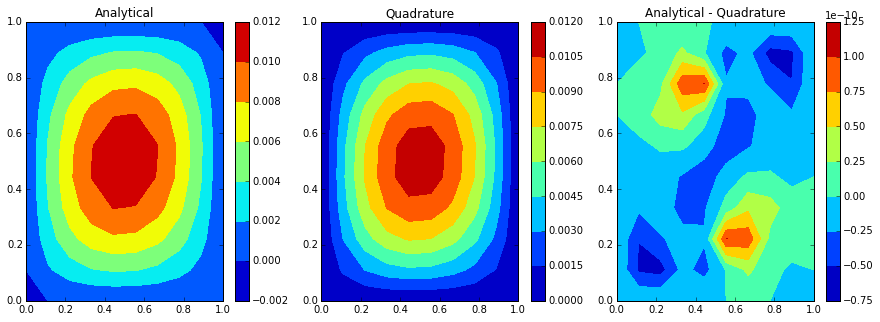

In [15]:
diagnose_function_2d(k, k_quad)

# Now we can calculate the Owhadi solution

In [71]:
def pairwise_apply(fun, A, B):
    res = np.empty((A.shape[0], B.shape[0]))
    for i in range(A.shape[0]):
        for j in range(B.shape[0]):
            res[i,j] = fun(A[i,:], B[j,:])
    return res

def kfun(k):
    fun = np.vectorize(k)
    return lambda x, y: pairwise_apply(fun, x, y)

In [144]:
k_eval = kfun(k)
A_k = kfun(Ak)
Abar_k = kfun(Abark)
AAbar_k = kfun(Lambda)

In [153]:
X = np.linspace(0,1,8)[1:-1,None]
g = np.sin(2*np.pi*X)
test_points = np.linspace(0,1,10)[:,None]

def get_cov(X):
    return k_eval(test_points, test_points) - Abar_k(test_points, X).dot(np.linalg.inv(AAbar_k(X, X))).dot(A_k(X, test_points))

In [154]:
optimizer = bd.optimizers.gpyopt_optimizer(lambda x: [(x[0] - 0.1,x[0]+0.1)])
loss = bd.a_optimality(get_cov)
best_X = bd.ace(X, 1, 10, loss, optimizer, True)

0 Moved 4 from [ 0.71428571] to [ 0.70526084] (new loss 7.60e-12 < 8.01e-12)
1 Moved 1 from [ 0.28571429] to [ 0.29213143] (new loss 7.25e-12 < 7.60e-12)
2 Rejected move of 1 from [ 0.29213143] to [ 0.30124325], (new loss 7.45e-12 > 7.25e-12)
3 Moved 1 from [ 0.29213143] to [ 0.29272914] (new loss 7.24e-12 < 7.25e-12)
4 Rejected move of 1 from [ 0.29272914] to [ 0.30978533], (new loss 8.44e-12 > 7.24e-12)
5 Rejected move of 1 from [ 0.29272914] to [ 0.29891593], (new loss 7.32e-12 > 7.24e-12)
6 Rejected move of 1 from [ 0.29272914] to [ 0.29794289], (new loss 7.29e-12 > 7.24e-12)
7 Rejected move of 1 from [ 0.29272914] to [ 0.29209511], (new loss 7.26e-12 > 7.24e-12)
8 Rejected move of 1 from [ 0.29272914] to [ 0.2916783], (new loss 7.27e-12 > 7.24e-12)
9 Rejected move of 1 from [ 0.29272914] to [ 0.29823159], (new loss 7.30e-12 > 7.24e-12)


In [155]:
test_points = np.linspace(0,1,101)[:, None]
mu = Abar_k(test_points, best_X).dot(np.linalg.inv(AAbar_k(best_X, best_X))).dot(g)
Sigma = k_eval(test_points, test_points) - Abar_k(test_points, best_X).dot(np.linalg.inv(AAbar_k(best_X, best_X))).dot(A_k(best_X, test_points))

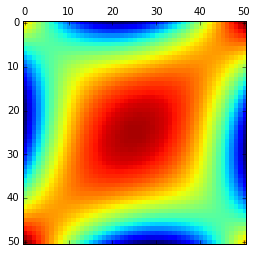

In [156]:
plt.matshow(mat)

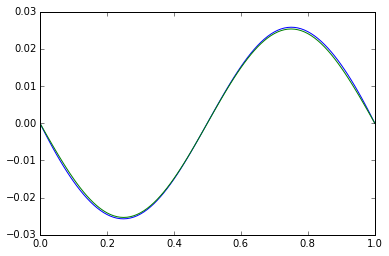

In [157]:
plt.plot(test_points, mu)
plt.plot(test_points, -np.sin(2*np.pi*test_points) / (4*np.pi**2))

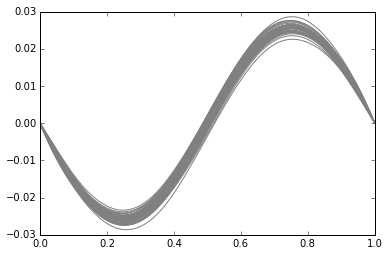

In [158]:
samps = np.random.multivariate_normal(mu.ravel(), Sigma, 50)
plt.plot(test_points, samps.T, c='gray');

In [159]:

plt.figure(figsize=(10,3))
#plt.ylim(-0.15,0.15)

a = gpanim.animate_gp(test_points, mu, Sigma, 10, plot_kwargs={'c': 'gray'})
plt.plot(test_points, mu, c='red', linewidth=3, linestyle='--', label='Mean')
plt.plot(test_points, -np.sin(2*np.pi*test_points) / (4*np.pi**2), c='lime', linewidth=3, linestyle='-.', label='Analytic')
plt.legend();
for pt in best_X:
    plt.axvline(pt, c='gray', linestyle='--')
plt.title('L = {}'.format(np.sum(np.trace(Sigma)**2)))
a

# TODO
Is it possible to show that this performance is in any way better? i.e. can I use the same sort of kernel in the 'collocation' approach and show that the performance is worse?